In [60]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

max_batch = 200
max_step = 40
feature = 200

def padding(filename):
    train_data = pickle.load(open(filename, 'rb'))
    train_inputs = train_data['inputs']
    train_targets = train_data['targets']
    print(train_inputs['13_0'].shape)
    print(train_targets['13_0'].shape)
    padded_inputs = dict()
    padded_targets = dict()
    for key in train_inputs.keys():
        temp = train_inputs[key]
        temp2 = train_targets[key]
        if temp.shape[0] != max_batch and temp.shape[0] != 0:
    #         print(temp.shape)
    #         print(50-len(temp))
    #         print(np.zeros((50 - temp.shape[0], temp.shape[1], 200)).shape)
            temp = np.concatenate((temp, np.zeros((max_batch - temp.shape[0], temp.shape[1], feature))), 0)
            temp2 = np.concatenate((temp2, np.zeros((max_batch - temp2.shape[0], 134))), 0)
    #         print(temp.shape)
            temp = np.concatenate((temp, np.zeros((max_batch, max_step - temp.shape[1], feature))), 1)
            padded_inputs[key] = temp
            padded_targets[key] = temp2
        elif temp.shape[0] == max_batch and temp.shape[0] != 0:
            temp = np.concatenate((temp, np.zeros((max_batch, max_step - temp.shape[1], feature))), 1)
            padded_inputs[key] = temp
            padded_targets[key] = train_targets[key]
    print(padded_inputs['13_1'].shape)
    print(padded_targets['13_1'].shape)
    return padded_inputs, padded_targets
    
# padded_inputs, padded_targets = padding('../word2vec/anouymous_train_data_200.npz')
# padded_test_inputs, padded_test_targets  = padding('../word2vec/anouymous_valid_data_200.npz')

padded_inputs, padded_targets = pickle.load(open('../word2vec/anouymous_padded_train_data.npz', 'rb')).values()
padded_test_inputs, padded_test_targets  = pickle.load(open('../word2vec/anouymous_padded_valid_data.npz', 'rb')).values()

In [61]:
padded_inputs = np.reshape(padded_inputs, [670, 200, 20, 200])
padded_targets = np.reshape(padded_targets, [670, 200, 134])
padded_test_inputs = np.reshape(padded_test_inputs, [67, 200, 20, 200])
padded_test_targets = np.reshape(padded_test_targets, [67, 200, 134])

In [62]:
def init(shape):
    return tf.Variable(tf.truncated_normal(shape), tf.float32)

def lstm_layer(inputs, batch_size, step_size):
    with tf.name_scope('lstm'):
        shape = inputs.shape.as_list()
        batch_size = shape[0]
        step_size = shape[1]
        n_units = shape[2]
    #     print(batch_size)
    #     print(step_size)

        wf = init([n_units, n_units])
        bf = init([n_units])

        wi = init([n_units, n_units])
        bi = init([n_units])

        wc = init([n_units, n_units])
        bc = init([n_units])

        wo = init([n_units, n_units])
        bo = init([n_units])

        ht = init([batch_size, n_units])
        ct = init([1, n_units])

        ct_tiled = tf.tile(ct, [batch_size, 1])

#         W = tf.transpose(tf.tile(tf.concat([wf, wi, wc, wo], 0), [1, 2]), [1, 0])
#         B = tf.concat([bf, bi, bc, bo], 0)
        W = tf.concat([wf, wi, wc, wo], 0)
        B = tf.concat([bf, bi, bc, bo], 0)

#         temp = (np.dot(W, x.T) + np.dot(W, h.T)).T + B

#         t1, t2, t3, t4 = np.split(temp, indices_or_sections=4 ,axis=1)

        for i in range(step_size):
            xt = inputs[:, i, :]
#             X = tf.concat([ht, xt], 1)
#             V = tf.matmul(X, W) + B
            V = tf.transpose(tf.matmul(W, tf.transpose(xt, [1, 0])) + tf.matmul(W, tf.transpose(ht, [1,0])), [1,0]) + B
    
            ft, it, c, ot = tf.split(V, num_or_size_splits=4, axis=1)
            ft = tf.sigmoid(ft)
            it = tf.sigmoid(it)
            c = tf.tanh(c)
            ot = tf.sigmoid(ot)
            ct = tf.reshape(tf.reduce_mean(ft * ct_tiled + it * c, 0), [1, n_units])
            ht = ot * tf.tile(tf.tanh(ct), [batch_size, 1])
        
    return ht, ct

In [64]:
max_batch = 200
max_step = 20
feature = 200
graph = tf.Graph()
with graph.as_default():
    
    batch_size = max_batch
    step_size = max_step
    
    inputs_placeholder = tf.placeholder(tf.float32, [batch_size, step_size, feature])
    targets_placeholder = tf.placeholder(tf.float32, [batch_size, 134])
#     batch_size = tf.placeholder(tf.int32)
#     step_size = tf.placeholder(tf.int32)
    
#     outputs, states = tf.nn.dynamic_rnn(
#             cell = tf.contrib.rnn.BasicLSTMCell(num_units=200),
#             inputs = inputs_placeholder,
#             dtype = tf.float32)
        
#     print(outputs)
#     print(cells)
    outputs, states = lstm_layer(inputs_placeholder, batch_size, step_size)
    
    w1 = init([200, 128])
    b1 = init([128])
    
#     w2 = init([128, 128])
#     b2 = init([128])
    
    w3 = init([128, 134])
    b3 = init([134])
    
    o1 = tf.nn.relu(tf.add(tf.matmul(outputs, w1), b1))
#     o2 = tf.nn.relu(tf.add(tf.matmul(o1, w2), b2))
    o3 = tf.nn.relu(tf.add(tf.matmul(o1, w3), b3))
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=o3, labels=targets_placeholder))
    sum_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=o3, labels=targets_placeholder))
    optimizer = tf.train.AdamOptimizer(1e-2).minimize(loss)
    accuracy = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(o3, 1), tf.argmax(targets_placeholder, 1)), tf.float32))
    
    sess = tf.Session()
    
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('../outputs/', sess.graph)
    sess.run(tf.global_variables_initializer())
    
#     keys = padded_inputs.keys()
#     test_keys = padded_test_inputs.keys()
    print('TRAINING PROCESS START...')
    for i in range(100):
        accs = 0.0
        errs = 0.0
        n = 0
        print('#EPOCH => %d'%(i))
        for batch_inputs, batch_targets in zip(padded_inputs[:10], padded_targets[:10]):
            batch_size = len(batch_inputs)
            n += batch_size
            feed_dict = {inputs_placeholder:batch_inputs, targets_placeholder:batch_targets}#, batch_size:batch_size, step_size:step_size}
            _, acc, err = sess.run([optimizer, accuracy, sum_loss], feed_dict=feed_dict)
            accs += acc
            errs += err
#         writer.add_summary(m, i)
        print('#Trainig Epoch: %d, ACC:%f, ERR:%f, N:%d'%(i, accs/n, errs/n, n))
        if i % 5 == 0:
            accs = 0.0
            errs = 0.0
            n = 0
            for batch_inputs, batch_targets in zip(padded_test_inputs[:], padded_test_targets[:]):
                batch_size = len(batch_inputs)
                n += batch_size
                feed_dict = {inputs_placeholder:batch_inputs, targets_placeholder:batch_targets}#, batch_size:batch_size, step_size:step_size}
                acc, err = sess.run([accuracy, sum_loss], feed_dict=feed_dict)
                accs += acc
                errs += err
            print('------------------------------------------------------------------')
            print('#Testing Epoch: %d, ACC:%f, ERR:%f, N:%d'%(i, accs/n, errs/n, n))
            print('------------------------------------------------------------------')
            

TRAINING PROCESS START...
#EPOCH => 0
#Trainig Epoch: 0, ACC:0.000000, ERR:1340.867273, N:2000
------------------------------------------------------------------
#Testing Epoch: 0, ACC:0.012612, ERR:813.822926, N:13400
------------------------------------------------------------------
#EPOCH => 1
#Trainig Epoch: 1, ACC:0.003000, ERR:584.895867, N:2000
#EPOCH => 2
#Trainig Epoch: 2, ACC:0.002500, ERR:239.193082, N:2000
#EPOCH => 3
#Trainig Epoch: 3, ACC:0.005000, ERR:139.201683, N:2000
#EPOCH => 4
#Trainig Epoch: 4, ACC:0.000000, ERR:114.746221, N:2000
#EPOCH => 5
#Trainig Epoch: 5, ACC:0.000000, ERR:104.096561, N:2000
------------------------------------------------------------------
#Testing Epoch: 5, ACC:0.000373, ERR:104.460866, N:13400
------------------------------------------------------------------
#EPOCH => 6
#Trainig Epoch: 6, ACC:0.000000, ERR:96.488470, N:2000
#EPOCH => 7
#Trainig Epoch: 7, ACC:0.000000, ERR:102.071592, N:2000
#EPOCH => 8
#Trainig Epoch: 8, ACC:0.000000, ERR

KeyboardInterrupt: 

In [7]:
batch = 50
size = 10
# wf = np.random.random((size, size))
# bf = np.random.random(size)
# wi = np.random.random((size, size))
# bi = np.random.random(size)
# wc = np.random.random((size, size))
# bc = np.random.random(size)
# wo = np.random.random((size, size))
# bo = np.random.random(size)
# x = np.random.random((batch, size))
# h = np.random.random((batch, size))
wf = np.arange(size*size).reshape(size, size)
bf = np.arange(size)
wi = np.arange(size*size).reshape(size, size)
bi = np.arange(size)
wc = np.arange(size*size).reshape(size, size)
bc = np.arange(size)
wo = np.arange(size*size).reshape(size, size)
bo = np.arange(size)
x = np.arange(batch*size).reshape(batch, size)
h = np.arange(batch*size).reshape(batch, size)

(50, 10)
(50, 10)
True


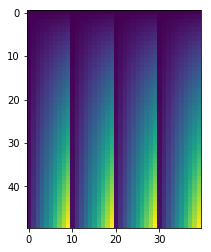

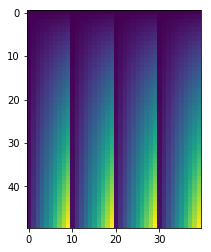

In [52]:
ft = (np.dot(wf, x.T) + np.dot(wf, h.T)).T + bf
it = (np.dot(wi, x.T) + np.dot(wi, h.T)).T + bi
ot = (np.dot(wo, x.T) + np.dot(wo, h.T)).T + bo
ct = (np.dot(wc, x.T) + np.dot(wc, h.T)).T + bc



W = np.concatenate([wf, wi, wc, wo], 0)
B = np.concatenate([bf, bi, bc, bo], 0)

temp = (np.dot(W, x.T) + np.dot(W, h.T)).T + B

t1, t2, t3, t4 = np.split(temp, indices_or_sections=4 ,axis=1)
# t1 = t1.T
# t2 = t2
print(t1.shape)
print(ft.shape)
plt.imshow(np.concatenate([ft, it, ct, ot], 1))
plt.figure()
plt.imshow(np.concatenate([t1, t2, t3, t4], 1))
print((ft == t1).all() and (it == t2).all() and (ot == t3).all() and (ct == t4).all())